# Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
batch = []
for _ in range(1000):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], batch[0][1].shape

([0,
  array([ 0.00056895, -0.15890157, -0.03950566,  0.25282528]),
  1.0,
  False,
  {}],
 (4,))

In [6]:
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(1000,) (1000, 4) (1000,) (1000,)
float64 float64 int64 bool
1 0
2
1.0 1.0
2.5689499699082914 -2.6957160095074584


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [49]:
# Data of the model
def model_input(state_size):
    # Calculating Qs
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    
    # returning the given data to the model
    return actions, states, rewards

In [50]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [51]:
def model_loss(actions, states, rewards, # Calculating Qs
               action_size, hidden_size): # model init for Qs
        
    # calculate Qs and targetQs
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    rewarded_actions_logits = tf.multiply(actions_logits, tf.reshape(rewards, shape=[-1, 1]))
    
    actions_onehot = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    rewarded_actions_onehot = tf.multiply(actions_onehot, tf.reshape(rewards, shape=[-1, 1]))
    
    # Qs_onehot = tf.multiply(rewarded_actions_logits[:-1], actions_onehot[1:])
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=rewarded_actions_logits[:-1], 
                                                                     labels=rewarded_actions_onehot[1:]))
    
    return actions_logits, loss

In [52]:
def model_opt(loss, learning_rate):
    """
    Get optimization operations in order
    :param loss: Generator loss Tensor for action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [53]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states, self.rewards = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            rewards=self.rewards, states=self.states, actions=self.actions) # alculating targetQs/nextQs

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [54]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [55]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print(np.max(actions) - np.min(actions)+1)

state size:(50, 4) actions:(50,)
2


In [56]:
# Training parameters
train_episodes = 2000          # max number of episodes to learn from
max_steps = 3000000000         # max steps in an episode
learning_rate = 0.001          # learning rate for adam

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
batch_size = 50                # number of samples in the memory/ experience as mini-batch size

In [57]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=batch_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [58]:
# Initialize the simulation
env.reset()

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    
    # Take one random step to get the pole and cart moving
    action = env.action_space.sample()
    state, _, done, _ = env.step(action)
    reward = 1 - float(done)
    memory.buffer.append((action, state, reward))
    
    # End of the episodes which defines the goal of the episode/mission
    if done is True:
        # Start new episode
        env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [59]:
state, reward, action

(array([ 0.0509383 , -0.15616925, -0.1034863 ,  0.04176656]), 1.0, 1)

In [60]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting after training session/graph
rewards_list = [] # accuracy
loss_list = [] # loss

# TF session for training
with tf.Session() as sess:
    
    # Initialize/restore variables
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Explore or exploit parameter
    total_step = 0
    
    # Training episodes/epochs
    for ep in range(train_episodes):
        
        # Start new episode
        env.reset()
        total_reward = 0
        loss_batch = []

        # Training steps/batches
        for _ in range(max_steps): # start=0, step=1, stop=max_steps/done/reward
            
            # Batch from the OLD memory
            batch = memory.buffer
            #actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            
            # Calculating next action using OLD memory
            actions_logits = sess.run(model.actions_logits, feed_dict={model.states: states})
            rewarded_actions_logits = np.multiply(actions_logits, np.reshape(rewards, [-1, 1]))
            last_action_logits = rewarded_actions_logits[-1]
            
            # Explore (Env) or Exploit (Model)
            # Take new action, get new state and reward
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                action = np.argmax(last_action_logits)
            state, _, done, _ = env.step(action)
            reward = 1 - float(done)
            
            # New memory (time direction)
            memory.buffer.append((action, state, reward))
            
            # Cumulative rewards
            total_reward += reward

            # Batch from NEW memory
            batch = memory.buffer
            actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
                
            # Updating the model using NEW memory and targetQs/nextQs
            feed_dict = {model.actions: actions,
                         model.states: states, 
                         model.rewards: rewards}
            
            if total_reward > 50:
                loss, _ = sess.run([model.loss, model.opt], feed_dict)
            else:
                loss = sess.run(model.loss, feed_dict)

            # For average loss in one episode/epoch
            loss_batch.append(loss)

            # At the end of steps/batches loop
            if done is True:
                break
                
        # At the end of each episode/epoch
        print('-------------------------------------------------------------------------------')
        print('Episode: {}'.format(ep),
              'Total reward: {}'.format(total_reward),
              'Average loss: {:.9f}'.format(np.mean(loss_batch)),
              'Explore P: {:.9f}'.format(explore_p))
        print('-------------------------------------------------------------------------------')

        # At the end of each episode/epoch
        # total rewards and losses for plotting
        rewards_list.append((ep, total_reward))
        loss_list.append((ep, np.mean(loss_batch)))
        
    # At the end of all training episodes/epochs
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 12.0 Average loss: 0.664432108 Explore P: 0.998713836
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 20.0 Average loss: 0.649357200 Explore P: 0.996639716
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 14.0 Average loss: 0.647544265 Explore P: 0.995160866
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 20.0 Average loss: 0.643523574 Explore P: 0.993094199
-------------------------------------------------------------------------------
--------------------------------------------

-------------------------------------------------------------------------------
Episode: 35 Total reward: 17.0 Average loss: 0.708717942 Explore P: 0.926081141
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 36 Total reward: 21.0 Average loss: 0.700031519 Explore P: 0.924067978
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 37 Total reward: 29.0 Average loss: 0.664616466 Explore P: 0.921329883
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 38 Total reward: 25.0 Average loss: 0.648312330 Explore P: 0.918963503
-------------------------------------------------------------------------------
----------------------------------------

-------------------------------------------------------------------------------
Episode: 71 Total reward: 13.0 Average loss: 0.866940439 Explore P: 0.823303984
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 72 Total reward: 17.0 Average loss: 0.790977478 Explore P: 0.821841353
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 73 Total reward: 19.0 Average loss: 0.739727199 Explore P: 0.820219293
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 74 Total reward: 102.0 Average loss: 0.617089808 Explore P: 0.811916865
-------------------------------------------------------------------------------
---------------------------------------

-------------------------------------------------------------------------------
Episode: 107 Total reward: 53.0 Average loss: 0.707401335 Explore P: 0.739606205
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 108 Total reward: 40.0 Average loss: 0.604265273 Explore P: 0.736620943
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 109 Total reward: 62.0 Average loss: 0.640358329 Explore P: 0.732057621
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 110 Total reward: 36.0 Average loss: 0.578272462 Explore P: 0.729390944
-------------------------------------------------------------------------------
------------------------------------

-------------------------------------------------------------------------------
Episode: 141 Total reward: 39.0 Average loss: 0.791710973 Explore P: 0.651946485
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 142 Total reward: 18.0 Average loss: 0.780866086 Explore P: 0.650727944
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 143 Total reward: 18.0 Average loss: 0.671638012 Explore P: 0.649511717
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 144 Total reward: 10.0 Average loss: 0.937662542 Explore P: 0.648808641
-------------------------------------------------------------------------------
------------------------------------

-------------------------------------------------------------------------------
Episode: 175 Total reward: 105.0 Average loss: 0.580215871 Explore P: 0.547057381
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 176 Total reward: 121.0 Average loss: 0.591400325 Explore P: 0.540545086
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 177 Total reward: 79.0 Average loss: 0.645312965 Explore P: 0.536317658
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 178 Total reward: 33.0 Average loss: 0.727410674 Explore P: 0.534531217
-------------------------------------------------------------------------------
----------------------------------

-------------------------------------------------------------------------------
Episode: 209 Total reward: 11.0 Average loss: 0.754077256 Explore P: 0.452971283
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 210 Total reward: 14.0 Average loss: 0.718709886 Explore P: 0.452307324
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 211 Total reward: 13.0 Average loss: 0.454672307 Explore P: 0.451688527
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 212 Total reward: 10.0 Average loss: 0.626475573 Explore P: 0.451202937
-------------------------------------------------------------------------------
------------------------------------

-------------------------------------------------------------------------------
Episode: 244 Total reward: 17.0 Average loss: 0.765370965 Explore P: 0.385292208
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 245 Total reward: 13.0 Average loss: 0.661320806 Explore P: 0.384767166
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 246 Total reward: 11.0 Average loss: 0.609302104 Explore P: 0.384317715
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 247 Total reward: 10.0 Average loss: 0.518773615 Explore P: 0.383906192
-------------------------------------------------------------------------------
------------------------------------

-------------------------------------------------------------------------------
Episode: 280 Total reward: 13.0 Average loss: 0.610431254 Explore P: 0.366346989
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 281 Total reward: 19.0 Average loss: 0.700845301 Explore P: 0.365635007
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 282 Total reward: 12.0 Average loss: 0.591881514 Explore P: 0.365172982
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 283 Total reward: 13.0 Average loss: 0.589165032 Explore P: 0.364676087
-------------------------------------------------------------------------------
------------------------------------

-------------------------------------------------------------------------------
Episode: 315 Total reward: 190.0 Average loss: 0.508522809 Explore P: 0.323000549
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 316 Total reward: 197.0 Average loss: 0.482998997 Explore P: 0.316864089
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 317 Total reward: 199.0 Average loss: 0.431248486 Explore P: 0.310787773
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 318 Total reward: 199.0 Average loss: 0.455970228 Explore P: 0.304831776
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 349 Total reward: 131.0 Average loss: 0.323563248 Explore P: 0.212128765
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 350 Total reward: 65.0 Average loss: 0.356975287 Explore P: 0.210799108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 351 Total reward: 68.0 Average loss: 0.372416437 Explore P: 0.209418363
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 352 Total reward: 127.0 Average loss: 0.442429453 Explore P: 0.206882075
-------------------------------------------------------------------------------
----------------------------------

-------------------------------------------------------------------------------
Episode: 384 Total reward: 14.0 Average loss: 0.239973620 Explore P: 0.145911637
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 385 Total reward: 12.0 Average loss: 0.265287250 Explore P: 0.145735066
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 386 Total reward: 13.0 Average loss: 0.329572946 Explore P: 0.145545170
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 387 Total reward: 11.0 Average loss: 0.334251642 Explore P: 0.145382613
-------------------------------------------------------------------------------
------------------------------------

-------------------------------------------------------------------------------
Episode: 418 Total reward: 13.0 Average loss: 0.195224449 Explore P: 0.138664076
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 419 Total reward: 17.0 Average loss: 0.680438399 Explore P: 0.138432689
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 420 Total reward: 17.0 Average loss: 0.779139340 Explore P: 0.138201718
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 421 Total reward: 15.0 Average loss: 0.652998924 Explore P: 0.137996759
-------------------------------------------------------------------------------
------------------------------------

-------------------------------------------------------------------------------
Episode: 455 Total reward: 16.0 Average loss: 0.837939262 Explore P: 0.130784135
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 456 Total reward: 13.0 Average loss: 0.209612980 Explore P: 0.130615155
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 457 Total reward: 19.0 Average loss: 0.492189109 Explore P: 0.130374166
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 458 Total reward: 15.0 Average loss: 0.565911770 Explore P: 0.130181721
-------------------------------------------------------------------------------
------------------------------------

-------------------------------------------------------------------------------
Episode: 491 Total reward: 13.0 Average loss: 0.683875501 Explore P: 0.123841251
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 492 Total reward: 18.0 Average loss: 0.412073374 Explore P: 0.123625158
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 493 Total reward: 15.0 Average loss: 0.221072033 Explore P: 0.123443503
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 494 Total reward: 17.0 Average loss: 0.534745932 Explore P: 0.123239488
-------------------------------------------------------------------------------
------------------------------------

-------------------------------------------------------------------------------
Episode: 526 Total reward: 15.0 Average loss: 0.443152010 Explore P: 0.117394068
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 527 Total reward: 13.0 Average loss: 0.551873088 Explore P: 0.117243821
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 528 Total reward: 12.0 Average loss: 0.831487000 Explore P: 0.117104495
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 529 Total reward: 20.0 Average loss: 1.558535814 Explore P: 0.116879811
-------------------------------------------------------------------------------
------------------------------------

-------------------------------------------------------------------------------
Episode: 562 Total reward: 19.0 Average loss: 0.441479027 Explore P: 0.111129810
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 563 Total reward: 15.0 Average loss: 0.549192250 Explore P: 0.110968132
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 564 Total reward: 18.0 Average loss: 0.810181916 Explore P: 0.110776475
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 565 Total reward: 14.0 Average loss: 0.445569158 Explore P: 0.110625423
-------------------------------------------------------------------------------
------------------------------------

-------------------------------------------------------------------------------
Episode: 597 Total reward: 16.0 Average loss: 0.447565466 Explore P: 0.105517067
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 598 Total reward: 17.0 Average loss: 0.367696851 Explore P: 0.105345291
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 599 Total reward: 15.0 Average loss: 0.496501774 Explore P: 0.105192860
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 600 Total reward: 14.0 Average loss: 0.563680828 Explore P: 0.105050178
-------------------------------------------------------------------------------
------------------------------------

-------------------------------------------------------------------------------
Episode: 633 Total reward: 15.0 Average loss: 0.579451680 Explore P: 0.099963582
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 634 Total reward: 17.0 Average loss: 0.564184904 Explore P: 0.099801793
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 635 Total reward: 16.0 Average loss: 0.450918525 Explore P: 0.099649260
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 636 Total reward: 12.0 Average loss: 0.526064098 Explore P: 0.099532791
-------------------------------------------------------------------------------
------------------------------------

-------------------------------------------------------------------------------
Episode: 667 Total reward: 15.0 Average loss: 0.522817552 Explore P: 0.095132166
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 668 Total reward: 19.0 Average loss: 0.559007585 Explore P: 0.094962072
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 669 Total reward: 14.0 Average loss: 0.560336053 Explore P: 0.094834724
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 670 Total reward: 17.0 Average loss: 0.404887348 Explore P: 0.094682159
-------------------------------------------------------------------------------
------------------------------------

-------------------------------------------------------------------------------
Episode: 704 Total reward: 18.0 Average loss: 0.485390514 Explore P: 0.089862383
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 705 Total reward: 15.0 Average loss: 0.396300018 Explore P: 0.089734706
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 706 Total reward: 15.0 Average loss: 0.109060258 Explore P: 0.089607232
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 707 Total reward: 12.0 Average loss: 0.161784634 Explore P: 0.089503810
-------------------------------------------------------------------------------
------------------------------------

-------------------------------------------------------------------------------
Episode: 740 Total reward: 13.0 Average loss: 0.236946508 Explore P: 0.085196519
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 741 Total reward: 16.0 Average loss: 0.183980823 Explore P: 0.085068794
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 742 Total reward: 14.0 Average loss: 0.148143291 Explore P: 0.084956275
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 743 Total reward: 16.0 Average loss: 0.202769831 Explore P: 0.084828958
-------------------------------------------------------------------------------
------------------------------------

-------------------------------------------------------------------------------
Episode: 778 Total reward: 16.0 Average loss: 0.100476861 Explore P: 0.080541765
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 779 Total reward: 16.0 Average loss: 0.108772196 Explore P: 0.080421946
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 780 Total reward: 14.0 Average loss: 0.111103661 Explore P: 0.080316392
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 781 Total reward: 18.0 Average loss: 0.423185259 Explore P: 0.080182918
-------------------------------------------------------------------------------
------------------------------------

-------------------------------------------------------------------------------
Episode: 816 Total reward: 18.0 Average loss: 0.530985653 Explore P: 0.076327523
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 817 Total reward: 15.0 Average loss: 0.565179288 Explore P: 0.076221484
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 818 Total reward: 15.0 Average loss: 0.520556569 Explore P: 0.076115614
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 819 Total reward: 18.0 Average loss: 0.451725960 Explore P: 0.075990114
-------------------------------------------------------------------------------
------------------------------------

-------------------------------------------------------------------------------
Episode: 851 Total reward: 17.0 Average loss: 0.106139660 Explore P: 0.072558677
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 852 Total reward: 15.0 Average loss: 0.103944868 Explore P: 0.072458663
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 853 Total reward: 14.0 Average loss: 0.102964811 Explore P: 0.072365045
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 854 Total reward: 18.0 Average loss: 0.397762477 Explore P: 0.072246664
-------------------------------------------------------------------------------
------------------------------------

-------------------------------------------------------------------------------
Episode: 885 Total reward: 15.0 Average loss: 0.581367850 Explore P: 0.069068923
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 886 Total reward: 15.0 Average loss: 0.247756764 Explore P: 0.068974488
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 887 Total reward: 16.0 Average loss: 0.332711607 Explore P: 0.068874317
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 888 Total reward: 17.0 Average loss: 0.324358374 Explore P: 0.068768438
-------------------------------------------------------------------------------
------------------------------------

-------------------------------------------------------------------------------
Episode: 919 Total reward: 15.0 Average loss: 0.426633894 Explore P: 0.065801734
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 920 Total reward: 20.0 Average loss: 0.794754207 Explore P: 0.065684673
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 921 Total reward: 17.0 Average loss: 0.606127620 Explore P: 0.065584531
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 922 Total reward: 17.0 Average loss: 0.436007410 Explore P: 0.065484569
-------------------------------------------------------------------------------
------------------------------------

-------------------------------------------------------------------------------
Episode: 955 Total reward: 15.0 Average loss: 0.343259871 Explore P: 0.062625718
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 956 Total reward: 15.0 Average loss: 0.157456309 Explore P: 0.062541585
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 957 Total reward: 14.0 Average loss: 0.139709413 Explore P: 0.062462831
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 958 Total reward: 22.0 Average loss: 0.682170808 Explore P: 0.062342305
-------------------------------------------------------------------------------
------------------------------------

-------------------------------------------------------------------------------
Episode: 991 Total reward: 19.0 Average loss: 0.660679996 Explore P: 0.059546169
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 992 Total reward: 13.0 Average loss: 0.430527031 Explore P: 0.059476853
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 993 Total reward: 15.0 Average loss: 0.446175009 Explore P: 0.059397753
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 994 Total reward: 13.0 Average loss: 0.195867270 Explore P: 0.059328645
-------------------------------------------------------------------------------
------------------------------------

-------------------------------------------------------------------------------
Episode: 1027 Total reward: 17.0 Average loss: 0.150929183 Explore P: 0.056660825
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1028 Total reward: 13.0 Average loss: 0.133335382 Explore P: 0.056595545
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1029 Total reward: 15.0 Average loss: 0.127847880 Explore P: 0.056521052
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1030 Total reward: 15.0 Average loss: 0.098171890 Explore P: 0.056446678
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 1064 Total reward: 16.0 Average loss: 0.111501329 Explore P: 0.053842556
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1065 Total reward: 13.0 Average loss: 0.114459708 Explore P: 0.053781219
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1066 Total reward: 16.0 Average loss: 0.103671610 Explore P: 0.053706854
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1067 Total reward: 17.0 Average loss: 0.109228581 Explore P: 0.053628253
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 1101 Total reward: 19.0 Average loss: 0.669805884 Explore P: 0.051157449
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1102 Total reward: 15.0 Average loss: 0.850084603 Explore P: 0.051091650
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1103 Total reward: 16.0 Average loss: 0.784335017 Explore P: 0.051021854
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1104 Total reward: 16.0 Average loss: 0.205333591 Explore P: 0.050952176
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 1138 Total reward: 17.0 Average loss: 0.227811411 Explore P: 0.048725757
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1139 Total reward: 16.0 Average loss: 0.162214324 Explore P: 0.048659979
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1140 Total reward: 15.0 Average loss: 0.108119816 Explore P: 0.048598173
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1141 Total reward: 15.0 Average loss: 0.135489345 Explore P: 0.048536465
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 1175 Total reward: 17.0 Average loss: 0.111914769 Explore P: 0.046394037
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1176 Total reward: 17.0 Average loss: 0.105292492 Explore P: 0.046328587
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1177 Total reward: 17.0 Average loss: 0.099629037 Explore P: 0.046263254
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1178 Total reward: 17.0 Average loss: 0.090431578 Explore P: 0.046198039
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 1212 Total reward: 17.0 Average loss: 0.188237846 Explore P: 0.044202712
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1213 Total reward: 17.0 Average loss: 0.184038579 Explore P: 0.044141203
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1214 Total reward: 16.0 Average loss: 0.136827499 Explore P: 0.044083212
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1215 Total reward: 16.0 Average loss: 0.094296716 Explore P: 0.044025320
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 1248 Total reward: 15.0 Average loss: 0.116710074 Explore P: 0.042140115
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1249 Total reward: 15.0 Average loss: 0.117119476 Explore P: 0.042088732
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1250 Total reward: 13.0 Average loss: 0.131222472 Explore P: 0.042043839
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1251 Total reward: 14.0 Average loss: 0.440954953 Explore P: 0.041995810
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 1286 Total reward: 14.0 Average loss: 0.123121493 Explore P: 0.040210965
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1287 Total reward: 18.0 Average loss: 0.397335649 Explore P: 0.040153619
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1288 Total reward: 13.0 Average loss: 0.428370208 Explore P: 0.040111433
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1289 Total reward: 17.0 Average loss: 0.442722917 Explore P: 0.040057281
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 1324 Total reward: 17.0 Average loss: 0.286627561 Explore P: 0.038363552
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1325 Total reward: 15.0 Average loss: 0.098408148 Explore P: 0.038318207
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1326 Total reward: 32.0 Average loss: 0.112828568 Explore P: 0.038224911
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1327 Total reward: 15.0 Average loss: 0.106841587 Explore P: 0.038179787
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 1361 Total reward: 14.0 Average loss: 0.114838079 Explore P: 0.036653086
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1362 Total reward: 14.0 Average loss: 0.158506379 Explore P: 0.036613136
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1363 Total reward: 14.0 Average loss: 0.164878234 Explore P: 0.036573247
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1364 Total reward: 15.0 Average loss: 0.154879570 Explore P: 0.036530763
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 1399 Total reward: 16.0 Average loss: 0.247618839 Explore P: 0.035035753
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1400 Total reward: 14.0 Average loss: 0.206685290 Explore P: 0.034998228
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1401 Total reward: 19.0 Average loss: 0.460520416 Explore P: 0.034948282
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1402 Total reward: 16.0 Average loss: 0.411123604 Explore P: 0.034905905
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 1434 Total reward: 16.0 Average loss: 0.100636095 Explore P: 0.033542445
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1435 Total reward: 15.0 Average loss: 0.119642511 Explore P: 0.033504807
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1436 Total reward: 18.0 Average loss: 0.338015288 Explore P: 0.033460190
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1437 Total reward: 13.0 Average loss: 0.415884435 Explore P: 0.033427369
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 1471 Total reward: 17.0 Average loss: 0.150688201 Explore P: 0.032080723
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1472 Total reward: 15.0 Average loss: 0.096501082 Explore P: 0.032045422
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1473 Total reward: 16.0 Average loss: 0.087057583 Explore P: 0.032007976
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1474 Total reward: 14.0 Average loss: 0.093579225 Explore P: 0.031974989
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 1506 Total reward: 16.0 Average loss: 0.394973755 Explore P: 0.030497541
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1507 Total reward: 15.0 Average loss: 0.112134740 Explore P: 0.030464771
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1508 Total reward: 15.0 Average loss: 0.113895684 Explore P: 0.030432054
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1509 Total reward: 16.0 Average loss: 0.110122323 Explore P: 0.030397349
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 1540 Total reward: 199.0 Average loss: 0.078901060 Explore P: 0.023021540
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1541 Total reward: 199.0 Average loss: 0.145008281 Explore P: 0.022763697
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1542 Total reward: 12.0 Average loss: 0.052495219 Explore P: 0.022747115
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1543 Total reward: 11.0 Average loss: 0.055187747 Explore P: 0.022731827
-------------------------------------------------------------------------------
------------------------------

-------------------------------------------------------------------------------
Episode: 1577 Total reward: 10.0 Average loss: 0.302005559 Explore P: 0.022004780
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1578 Total reward: 12.0 Average loss: 0.727746129 Explore P: 0.021989184
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1579 Total reward: 11.0 Average loss: 0.725932598 Explore P: 0.021974806
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1580 Total reward: 11.0 Average loss: 0.724753678 Explore P: 0.021960445
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 1614 Total reward: 11.0 Average loss: 0.062477928 Explore P: 0.021494917
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1615 Total reward: 10.0 Average loss: 0.061727777 Explore P: 0.021482280
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1616 Total reward: 11.0 Average loss: 0.278310567 Explore P: 0.021468509
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1617 Total reward: 11.0 Average loss: 0.711203277 Explore P: 0.021454755
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 1653 Total reward: 11.0 Average loss: 0.061302442 Explore P: 0.020984717
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1654 Total reward: 11.0 Average loss: 0.058941092 Explore P: 0.020971543
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1655 Total reward: 11.0 Average loss: 0.060119912 Explore P: 0.020958385
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1656 Total reward: 11.0 Average loss: 0.058941092 Explore P: 0.020945243
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 1689 Total reward: 10.0 Average loss: 0.061727438 Explore P: 0.020537127
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1690 Total reward: 10.0 Average loss: 0.061727583 Explore P: 0.020525543
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1691 Total reward: 10.0 Average loss: 0.063013837 Explore P: 0.020513971
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1692 Total reward: 10.0 Average loss: 0.196086228 Explore P: 0.020502412
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 1726 Total reward: 10.0 Average loss: 0.061744019 Explore P: 0.020109797
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1727 Total reward: 9.0 Average loss: 0.063672997 Explore P: 0.020099692
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1728 Total reward: 11.0 Average loss: 0.064851820 Explore P: 0.020087580
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1729 Total reward: 11.0 Average loss: 0.062481716 Explore P: 0.020075482
-------------------------------------------------------------------------------
---------------------------------

-------------------------------------------------------------------------------
Episode: 1763 Total reward: 12.0 Average loss: 1.256401062 Explore P: 0.019677513
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1764 Total reward: 11.0 Average loss: 1.255403638 Explore P: 0.019665907
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1765 Total reward: 11.0 Average loss: 0.631577671 Explore P: 0.019654315
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1766 Total reward: 13.0 Average loss: 0.911432385 Explore P: 0.019640808
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 1797 Total reward: 11.0 Average loss: 0.060119998 Explore P: 0.019307355
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1798 Total reward: 12.0 Average loss: 0.844469488 Explore P: 0.019295263
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1799 Total reward: 10.0 Average loss: 1.334165692 Explore P: 0.019285044
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1800 Total reward: 11.0 Average loss: 1.332773089 Explore P: 0.019273909
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 1832 Total reward: 10.0 Average loss: 0.059744064 Explore P: 0.018938832
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1833 Total reward: 11.0 Average loss: 0.062178642 Explore P: 0.018928112
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1834 Total reward: 12.0 Average loss: 0.063085429 Explore P: 0.018916513
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1835 Total reward: 12.0 Average loss: 0.060909145 Explore P: 0.018904929
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 1866 Total reward: 11.0 Average loss: 0.064914294 Explore P: 0.018596068
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1867 Total reward: 11.0 Average loss: 0.061377835 Explore P: 0.018585759
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1868 Total reward: 11.0 Average loss: 0.061377835 Explore P: 0.018575463
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1869 Total reward: 9.0 Average loss: 0.059491716 Explore P: 0.018566891
-------------------------------------------------------------------------------
---------------------------------

-------------------------------------------------------------------------------
Episode: 1902 Total reward: 10.0 Average loss: 0.059155419 Explore P: 0.018242510
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1903 Total reward: 10.0 Average loss: 0.060441431 Explore P: 0.018233449
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1904 Total reward: 10.0 Average loss: 0.060441539 Explore P: 0.018224397
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1905 Total reward: 11.0 Average loss: 0.062477682 Explore P: 0.018214533
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 1941 Total reward: 11.0 Average loss: 0.900215149 Explore P: 0.017874305
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1942 Total reward: 10.0 Average loss: 0.899143457 Explore P: 0.017865648
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1943 Total reward: 12.0 Average loss: 1.489691257 Explore P: 0.017855429
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1944 Total reward: 9.0 Average loss: 1.763095140 Explore P: 0.017847578
-------------------------------------------------------------------------------
---------------------------------

-------------------------------------------------------------------------------
Episode: 1978 Total reward: 10.0 Average loss: 0.910304427 Explore P: 0.017548168
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1979 Total reward: 10.0 Average loss: 0.375766486 Explore P: 0.017539870
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1980 Total reward: 12.0 Average loss: 0.071362019 Explore P: 0.017530075
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1981 Total reward: 10.0 Average loss: 0.059155449 Explore P: 0.017521796
-------------------------------------------------------------------------------
--------------------------------

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [61]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

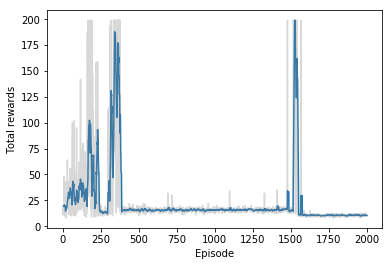

In [62]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

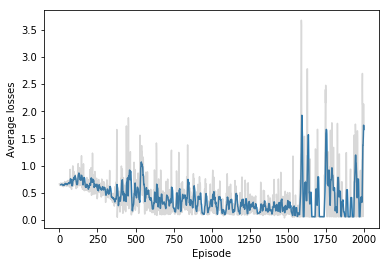

In [63]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [25]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

with tf.Session() as sess:

    # Initialize/restore/load the trained model 
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):

        # Start a new episode/epoch
        env.reset()
        
        # number of env/rob steps
        for _ in range(test_max_steps):
            
            # Rendering the env graphics
            env.render()
            
            # Batch from the OLD memory
            batch = memory.buffer
            #actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            
            # Calculating next action using OLD memory
            feed_dict={model.states: states}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            last_action_logits = actions_logits[-1]
            
            # Take action, get new state and reward
            #action = env.action_space.sample()
            action = np.argmax(last_action_logits)
            state, _, done, _ = env.step(action)
            reward = 1 - float(done)
            
            # New memory (time direction)
            memory.buffer.append((action, state, reward))
            
            # The task is done or not;
            if done:
                break
                
# Closing the env
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.